Theta is also available in the `statsmodels` and `statsforecast` libraries. Ours is 
much faster: we wrote a blog about it <link to follow>.


## 1. How the Theta algorithm works

The classical Theta method forecasts a univariate time series $y$ by four steps that 
combine a linear trend and a smoothed series describing variation around the trend. 


1. **Fit a linear trend** of $y$ against time estimated by ordinary least squares (the 
“θ=0 line”).  
$$\hat{y}^{\text{trend}}_t = a + bt$$  
2. **Form the theta line**, which combines the original series with the linear 
trend:

$$ \tilde{y}_t(\theta) = \theta\, y_t + (1-\theta)\, \hat{y}^{\text{trend}}_t,$$

3. **Smooth the theta line** using a simple exponential smoothing (SES) with 
smoothing parameter $\alpha$ to obtain the **level**:

$$
\ell_t = \alpha\, \tilde{y}_t + (1 - \alpha)\, \ell_{t-1}
$$
4. **Combine the level and trend** to form the forecast, using a weight parameter $w$:

$$
\hat{y}_{t+1} = (1 - w)\, \ell_t + w\, \hat{y}^{\text{trend}}_t
$$
The standard default parameter value is $\theta=2$ and $\alpha$ is found through grid
 search on range $(0,1]$ to find the value with the lowest sum of squared errors (SSE)
  on the train data. 
  

  <img src="img/theta.png" width="600" alt="Theta forecasting algorithm">


## 2. Parameters and their effects

- **`theta`** (default `2.0`): controls the curvature emphasis in the theta line.  
  - `>1` accentuates curvature; `<1` dampens it.
- **`weight`** (default `0.5`): convex combination weight for the **trend** component in the final forecast. The SES level gets `(1 - weight)`.
- **`alpha_`** (learned): SES smoothing parameter estimated on the theta line by minimising SSE.

Larger theta (e.g., 2 or 3) pushes the theta line farther from the trend, often 
yielding more curved behaviour in-sample and more sloped forecasts when combined with the trend (since the SES level shifts).

Smaller theta (e.g., 0.5) pulls the theta line toward the trend, typically producing flatter forecasts when weight stays at 0.5.
  <img src="img/theta_line.png" width="600" alt="Effects of theta on the theta line">

Increasing the weight shifts the forecast closer to the extrapolated trend, while decreasing it places more emphasis on the flat level from SES, producing a forecast that is less sensitive to the underlying slope.

  <img src="img/theta_weight.png" width="600" alt="Effects of theta on the theta line">


## 3. Forecasting with Theta

### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_airline
from aeon.forecasting.stats import Theta

### Synthetic example: fit and forecast

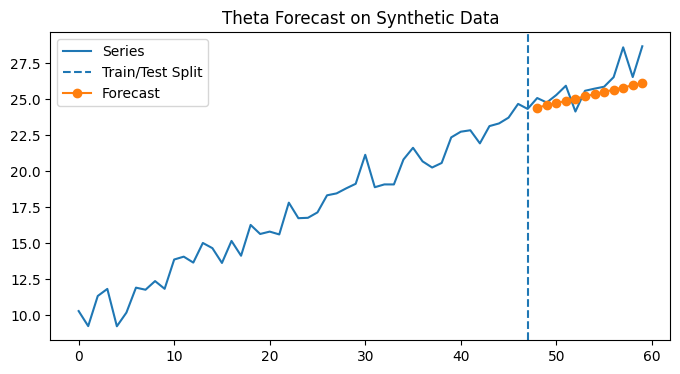

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [4]:
# Generate a synthetic trend + noise series
rng = np.random.default_rng(42)
n_points = 60
time = np.arange(n_points)
y = 10 + 0.3 * time + rng.normal(scale=1.0, size=n_points)

# Train/test split
y_train, y_test = y[:48], y[48:]

# Fit and forecast one ahead with aeon Theta
forecaster = Theta(theta=2.0, weight=0.5)
forecaster.fit(y_train)
y_pred = forecaster.forecast(y_train)

# Fit and forecast multiple steps ahead
y_preds = forecaster.iterative_forecast(y_train, prediction_horizon=12)
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time, y, label="Series")
plt.axvline(x=len(y_train) - 1, linestyle="--", label="Train/Test Split")
plt.plot(range(len(y_train), len(y)), y_preds, marker="o", label="Forecast")
plt.legend()
plt.title("Theta Forecast on Synthetic Data")
plt.show()

You will see that the forecast is a straight line, which is the extrapolated trend 
with a single weight of the level. This is the standard behaviour of the Theta 
forecaster. The trend is weighted with the next level. You cannot properly refit or 
update unless you know the true values. Classic theta will not perform well on 
seasonal data and is most appropriate for point forecasting. 

### 6. Airline passengers

Of course we have to do the airline data to make a point.


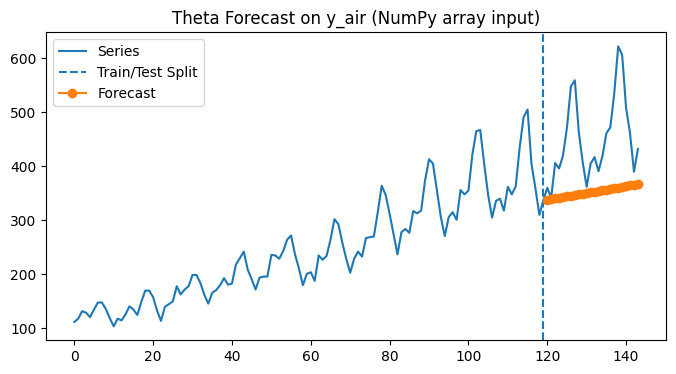

MSE on test set: 15085.202


In [7]:
y_air = load_airline().squeeze()
y_train, y_test = y_air[:-24], y_air[-24:]
# Plot
y_pred1 = Theta(theta=2.0, weight=0.5).iterative_forecast(
    y_train, prediction_horizon=24
)
time = np.arange(len(y_air))
plt.figure(figsize=(8, 4))
plt.plot(time, y_air, label="Series")
plt.axvline(x=len(y_train) - 1, linestyle="--", label="Train/Test Split")
plt.plot(np.arange(len(y_train), len(y_air)), y_pred, marker="o", label="Forecast")
plt.legend()
plt.title("Theta Forecast on y_air")
plt.show()

# MSE
mse = np.mean((y_test - y_pred) ** 2)
print(f"MSE on test set: {mse:.3f}")